TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


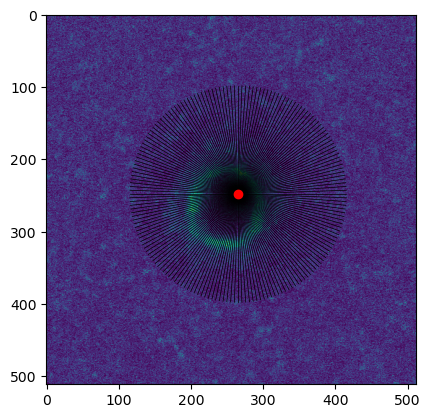

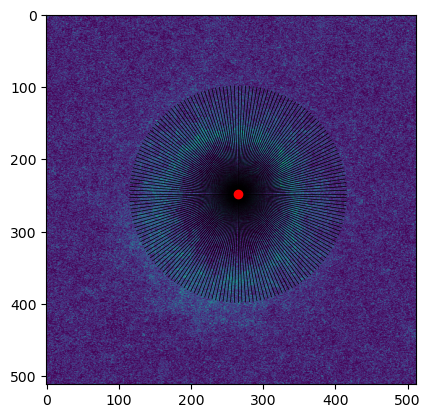

In [9]:
import glob,os
import sys
import math                   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile 
import pyclesperanto_prototype as cle
import scipy 
import scipy.signal as sig
import skimage.io as skio
from skimage.morphology import disk, binary_erosion, binary_dilation, binary_opening, binary_closing, remove_small_objects
from skimage.restoration import rolling_ball 
from skimage.measure import label
from skimage.filters import gaussian
import imageio
import logging

#################################################
#############   USER INPUTS   ###################
#################################################

num_lines = 180 #how many line scans per frame
line_length = 150 #choose you line length
bin_num = 150 #number of data points per line
image_folder_path = '/Users/domchom/Documents/GitHub/Dom_python_scripts/wound_close_quant/movies' #path to movie of interest

#################################################
#################################################
#################################################


def get_Images(folder_path):
    ''' saves all images in a dict {filepath: img as np array}'''
    all_images = {}
    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if file is a TIF file
        if filename.endswith('.tif'):
            # Open the TIF file using gdal
            filepath = os.path.join(folder_path, filename)

            img = tifffile.imread(filepath)

            # standardize image dimensions
            with tifffile.TiffFile(filepath) as tif_file:
                metadata = tif_file.imagej_metadata
            num_channels = metadata.get('channels', 1)
            num_slices = metadata.get('slices', 1)
            num_frames = metadata.get('frames', 1)
            img = img.reshape(num_frames, 
                            num_slices, 
                            num_channels, 
                            img.shape[-2], 
                            img.shape[-1])
            
            all_images[filepath] = img
    
    return all_images

#########################################################################
#finding the center of of the ring by masking each frame to display the ring, and then finding the center of mass of the ring. Then average each suitable (has a ring) frame.

def find_center(img):
    centroid_x = []
    centroid_y = []

    for n in range(len(img[0][0])):
        for i in range(len(img)):
            mask = img[i][0][n] > np.mean(img[i][0][n])*2 #masked the image
            blurred = gaussian(mask, 5) #blurring that first mask
            circle = blurred > np.mean(blurred)*5 #masking the mask
            circle_eroded4 = binary_erosion(circle, disk(1)) #to help with binary erosion
            circle_only = remove_small_objects(circle_eroded4, min_size=6000) #filtering out the smaller regions, like membrane folds
            labeled_circles = label(circle_only, connectivity=2) #for labelling the structures
            if np.mean(labeled_circles) == 0:
                pass
            else:
                #print(f'frame {i} contains a circle')
                #cle.imshow(labeled_circles, labels = True)
                cen = scipy.ndimage.center_of_mass(circle_only)
                centroid_x.append(cen[0])
                centroid_y.append(cen[1])

    center = [sum(centroid_x) / len(centroid_x),  sum(centroid_y) / len(centroid_y)]

    return center


def create_lines(center, num_of_lines, num):
    # Define the two ellipses
    line_coord_list = [] #list to fill with lines
    degree_diff = 360/num_of_lines #calc difference in degrees betweeen the lines
    radian_diff = math.radians(degree_diff)

    m = 0
    i = 0
    for line in range(num_of_lines):
        if i == 0: #first line
            x0, y0 = center[0], center[1] 
            x_length = (line_length * math.sin(i))
            x1 = center[0] + x_length
            y_length = math.sqrt((line_length**2) - (x_length**2))
            y1 = center[1] + y_length

            x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

            coords = [x,y]
            line_coord_list.append(coords)

            i += radian_diff
            m += 1
        else:
            if m < num_of_lines / 4:
                x0, y0 = center[0], center[1] 
                x_length = (line_length * math.sin(i))
                x1 = center[0] + x_length 
                y_length = math.sqrt((line_length**2) - (x_length**2))
                y1 = center[1] + y_length

                x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
                coords = [x,y]
                line_coord_list.append(coords)
            elif m < num_of_lines / 2:
                x0, y0 = center[0], center[1] 
                x_length = (line_length * math.sin(i))
                x1 = center[0] + x_length
                y_length = math.sqrt((line_length**2) - (x_length**2))
                y1 = center[1] - y_length

                x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
                coords = [x,y]
                line_coord_list.append(coords)
            elif m < ((num_of_lines / 2) + (num_of_lines / 4)):
                x0, y0 = center[0], center[1] 
                x_length = (line_length * math.sin(i + radian_diff))
                x1 = center[0] + x_length 
                y_length = math.sqrt((line_length**2) - (x_length**2))
                y1 = center[1] + y_length

                x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
                coords = [x,y]
                line_coord_list.append(coords)
            else:
                x0, y0 = center[0], center[1] 
                x_length = (line_length * math.sin(i + radian_diff))
                x1 = center[0] + x_length 
                y_length = math.sqrt((line_length**2) - (x_length**2))
                y1 = center[1] - y_length

                x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
                coords = [x,y]
                line_coord_list.append(coords)
    
            i += radian_diff
            m += 1
            
    return line_coord_list



def return_line_ref_figure(img, line_coords, center):
        # Plot the ellipses and lines
    fig, ax = plt.subplots()
    for coords in line_coords:
        ax.plot(coords[0], coords[1], 'k-', linewidth=0.5)
    ax.plot(center[0], center[1], 'ro')
    ax.set_aspect('equal', adjustable='box')
    ax.imshow(img)    
    fig.subplots_adjust(hspace=0.5)
    return fig

all_images = get_Images(image_folder_path)

all_ellipse_coords = {}

for key in all_images:
    center = find_center(all_images[key])

    all_ellipse_coords[key] = center

for filename in all_images:
    image = all_images[filename]
    line_coords =  create_lines(center, num_lines, bin_num)
    return_line_ref_figure(image[14][0][0], line_coords, center)
    
    if not os.path.exists("reference_lines"):
        os.mkdir("reference_lines")

    fig = return_line_ref_figure(image[14][0][0], line_coords, center)
    file_name = filename.split('.')[0]
    file_name = f"{file_name.split('/')[-1]}_ref.png"
    file_path = '/Users/domchom/Documents/GitHub/Dom_python_scripts/wound_close_quant/movies/reference_lines/' + file_name
    plt.close()
    fig.savefig(file_path)

In [ ]:


#perform the line scans
def calc_line_scans(img, num_frames, num_channels, line_coords):
    """
    Calculates the signal along each line in each frame of an image stack.

    Args:
        img (ndarray): A 3D numpy array of shape (num_frames, num_channels, image_shape).
        num_frames (int): The number of frames in the image stack.
        num_channels (int): The number of channels in the image stack.
        line_coords (list): A list of line coordinates, where each line is a list of x and y coordinates.

    Returns:
        list: A list of frames, where each frame is a list of signals, where each signal is an array of signal values.
    """
    frames_list = [] # store all the signals for every frame

    for c in range(num_channels): #iterate over the channels
        for f in range(num_frames): #iterate over the frames
            signals_list = [] #lost to store the signal for each line for the frame
            logging.info(f'Calculating channel {c+1}, frame {f+1}')

            for line in line_coords: #create each line for each frame
                x, y = line[0], line[1]
                x0, x1 = x[0], x[-1]
                y0, y1= y[0], y[-1]

                # Extract the values along the line, using cubic interpolation
                signal = scipy.ndimage.map_coordinates(img[f][0][c], np.vstack((x,y)))
                signals_list.append(signal)

            frames_list.append(signals_list)

            #plot_idv_lines(signal,f,c,x0,x1,y0,y1)

    logging.info(f'Finished calculating line scans for {num_frames} frames and {num_channels} channels')
    return frames_list

def plot_idv_lines(img, signal,f,c,x0,x1,y0,y1):
    fig, axes = plt.subplots(nrows=2)
    axes[0].imshow(img[f][0][c])
    axes[0].plot([x0, x1], [y0, y1], 'r-')
    axes[0].axis('image')

    axes[1].plot(signal)

    plt.show()

frames_list = calc_line_scans(img, num_frames, num_channels, line_coords)

2023-03-11 21:58:48,513 - INFO - Calculating channel 1, frame 1
2023-03-11 21:58:49,490 - INFO - Calculating channel 1, frame 2
2023-03-11 21:58:50,457 - INFO - Calculating channel 1, frame 3
2023-03-11 21:58:51,397 - INFO - Calculating channel 1, frame 4
2023-03-11 21:58:52,333 - INFO - Calculating channel 1, frame 5
2023-03-11 21:58:53,268 - INFO - Calculating channel 1, frame 6
2023-03-11 21:58:54,200 - INFO - Calculating channel 1, frame 7
2023-03-11 21:58:55,131 - INFO - Calculating channel 1, frame 8
2023-03-11 21:58:56,061 - INFO - Calculating channel 1, frame 9
2023-03-11 21:58:56,998 - INFO - Calculating channel 1, frame 10
2023-03-11 21:58:57,930 - INFO - Calculating channel 1, frame 11
2023-03-11 21:58:58,856 - INFO - Calculating channel 1, frame 12
2023-03-11 21:58:59,830 - INFO - Calculating channel 1, frame 13
2023-03-11 21:59:00,793 - INFO - Calculating channel 1, frame 14
2023-03-11 21:59:01,723 - INFO - Calculating channel 1, frame 15
2023-03-11 21:59:02,672 - INFO - C

KeyboardInterrupt: 

In [ ]:
frames_array = np.array(frames_list)

# Split the frames into two channels
channel1_raw_values, channel2_raw_values = np.array_split(frames_array, 2)

# Calculate the mean values for a channel
def calculate_mean_values(channel):
    '''
    Iterates over each frame of a np array containing (num_frames, num_lines in frame, num_bins in line).
    Averages each correspnding pixel on the line for each frame, and then returns a np
    array that contains (num_frames, one line in frame, num_bins in line)
    '''
    bin_num = channel.shape[-1]
    mean_values = []
    for frame in channel:
        pixel_avg_per_frame = []
        for n in range(bin_num):
            pixel_avg_per_frame.append(frame[:,n].mean())
        mean_values.append(pixel_avg_per_frame)

    return mean_values

# Calculate the mean values for each channel
raw_mean_values_Ch1 = calculate_mean_values(channel1_raw_values)
raw_mean_values_Ch2 = calculate_mean_values(channel2_raw_values)

# Combine the mean values for both channels into a single array
mean_values_both_ch = np.array([raw_mean_values_Ch1, raw_mean_values_Ch2])

In [ ]:
# Define variables for filter and normalization parameters
window_length = 11 #for smoothing the line
polyorder = 2 #for smoothing the line
norm_min = 0 #set the min value for normalization
norm_max = 1 #set the max value for normalization

# Define a function to normalize the data for a channel
def normalize_data(channel_raw_values):
    norm_values = []
    for signal in channel_raw_values:
        signal_max = np.max(signal)
        norm_signal = (signal / signal_max) * (norm_max - norm_min) + norm_min
        norm_values.append(norm_signal)
    return norm_values

# Define a function to subtract background from the data for a channel
def subtract_background(channel_raw_values, channel_ref_values):
    bg_values = np.min(channel_ref_values)
    norm_values = []
    for signal in channel_raw_values:
        signal_bg = (signal - bg_values) * (norm_max - norm_min) / (np.max(channel_ref_values) - bg_values)
        norm_values.append(signal_bg)
    return norm_values

# Normalize the data for each channel
norm_mean_values_Ch1 = normalize_data(raw_mean_values_Ch1)
norm_mean_values_Ch2 = normalize_data(raw_mean_values_Ch2)

# Subtract background from the data for each channel
mean_values_Ch1_norm_bg = subtract_background(raw_mean_values_Ch1, raw_mean_values_Ch1)
mean_values_Ch2_norm_bg = subtract_background(raw_mean_values_Ch2, raw_mean_values_Ch2)

#define a function to smooth data
def smooth_data(channel_values):
    smoothed_data = []
    for signal in channel_values:
        signal_smooth = scipy.signal.savgol_filter(signal, window_length=window_length, polyorder=polyorder)
        smoothed_data.append(signal_smooth)
    return smoothed_data

#smooth all data
raw_values_Ch1_smooth = smooth_data(raw_mean_values_Ch1)
raw_values_Ch2_smooth = smooth_data(raw_mean_values_Ch2)

mean_values_both_ch_smooth = np.array([raw_values_Ch1_smooth, raw_values_Ch2_smooth])

norm_mean_values_Ch1_smooth = smooth_data(norm_mean_values_Ch1)
norm_mean_values_Ch2_smooth = smooth_data(norm_mean_values_Ch2)

norm_mean_values_both_ch_smooth = np.array([norm_mean_values_Ch1_smooth, norm_mean_values_Ch2_smooth])

mean_values_Ch1_norm_bg_smooth = smooth_data(mean_values_Ch1_norm_bg)
mean_values_Ch2_norm_bg_smooth = smooth_data(mean_values_Ch2_norm_bg)

mean_values_both_ch_bg_smooth= np.array([mean_values_Ch1_norm_bg_smooth, mean_values_Ch2_norm_bg_smooth])

In [ ]:
#find peaks - will treat each frame like a box

# make empty arrays to fill with peak measurements for each channel
peak_widths = np.zeros(shape=(num_channels, num_frames))
peak_maxs = np.zeros(shape=(num_channels, num_frames))
peak_mins = np.zeros(shape=(num_channels, num_frames))

# make a dictionary to store the arrays and measurments generated by this function so they don't have to be re-calculated later
ind_peak_props = {}

for channel in range(num_channels):
    for frame_num in range(num_frames):

        signal = scipy.signal.savgol_filter(mean_values_both_ch[channel][frame_num], window_length = 11, polyorder = 2)
        peaks, _ = scipy.signal.find_peaks(signal, prominence=(np.max(signal)-np.min(signal))*0.65) #<--- edit last number to change the threshold

        # if peaks detected, calculate properties and return property averages. Otherwise return nans
        if len(peaks) > 0:
            proms, _, _ = scipy.signal.peak_prominences(signal, peaks)
            widths, heights, leftIndex, rightIndex = scipy.signal.peak_widths(signal, peaks, rel_height=0.5)
            mean_width = np.mean(widths, axis=0)
            mean_max = np.mean(signal[peaks], axis = 0)
            mean_min = np.mean(signal[peaks]-proms, axis = 0)
            peak_widths[channel, frame_num] = mean_width
            peak_maxs[channel, frame_num] = mean_max
            peak_mins[channel, frame_num] = mean_min

            # store the smoothed signal, peak locations, maxs, mins, and widths for each box in each channel
            ind_peak_props[f'Ch {channel} Box {frame_num}'] = {'smoothed': signal, 
                                                    'peaks': peaks,
                                                    'proms': proms, 
                                                    'heights': heights, 
                                                    'leftIndex': leftIndex, 
                                                    'rightIndex': rightIndex}
                
        else:
            peak_widths[channel, frame_num] = np.nan
            peak_maxs[channel, frame_num] = np.nan
            peak_mins[channel, frame_num] = np.nan

            # store the smoothed signal, peak locations, maxs, mins, and widths for each box in each channel
            # DC: might not acutally need this, as the code works fine without it (221222). Just putting for safety.
            ind_peak_props[f'Ch {channel} Frame {frame_num}'] = {'smoothed': np.nan, 
                                                    'peaks': np.nan,
                                                    'proms': np.nan, 
                                                    'heights': np.nan, 
                                                    'leftIndex': np.nan, 
                                                    'rightIndex': np.nan}

peak_amps = peak_maxs - peak_mins
peak_rel_amps = peak_amps / peak_mins


In [ ]:
# make a list of unique channel combinations to calculate CCF for
channels = list(range(num_channels))
channel_combos = []
for i in range(num_channels):
    for j in channels[i+1:]:
        channel_combos.append([channels[i],j])
num_combos = len(channel_combos)

# make empty arrays to populate with 1) period measurements and 2) acf curves   
shifts = np.zeros(shape=(num_combos, num_frames))
ccfs = np.zeros(shape=(num_combos, num_frames, bin_num*2-1))

for combo_number, combo in enumerate(channel_combos):
    for frame_num in range(num_frames):
    
        # calculate full cross-correlation
        signal1 = mean_values_both_ch[0][frame_num]
        signal2 = mean_values_both_ch[1][frame_num]

        peaks1, _ = scipy.signal.find_peaks(signal1, prominence=(np.max(signal)-np.min(signal))*0.15) #<--- edit last number to change the threshold
        peaks2, _ = scipy.signal.find_peaks(signal2, prominence=(np.max(signal)-np.min(signal))*0.15) #<--- edit last number to change the threshold

        if len(peaks1) > 0 and len(peaks2) > 0:
            corr_signal1 = signal1 - signal1.mean()
            corr_signal2 = signal2 - signal2.mean()
            cc_curve = np.correlate(corr_signal1, corr_signal2, mode='full')
            # normalize the curve
            cc_curve = scipy.signal.savgol_filter(cc_curve, window_length = 11, polyorder = 2)

            cc_curve = cc_curve / (num_frames * signal1.std() * signal2.std())

            peaks, _ = scipy.signal.find_peaks(cc_curve, prominence=0.01)
            
            # absolute difference between each peak and zero
            peaks_abs = abs(peaks - cc_curve.shape[0]//2)
            # if peaks were identified, pick the one closest to the center
            if len(peaks) > 1:
                delay = np.argmin(peaks_abs[np.nonzero(peaks_abs)])
                delayIndex = peaks[delay]
                delay_frames = delayIndex - cc_curve.shape[0]//2
            # otherwise, return nans for both period and autocorrelation curve
            else:
                delay_frames = np.nan
                cc_curve = np.full((bin_num*2-1), np.nan)
        else:
            delay_frames = np.nan
            cc_curve = np.full((bin_num*2-1), np.nan)

        shifts[combo_number, frame_num] = delay_frames
        ccfs[combo_number, frame_num] = cc_curve

In [ ]:
def cross_correlation(signal1, signal2, prominence):
    peaks1, _ = scipy.signal.find_peaks(signal1, prominence=prominence)
    peaks2, _ = scipy.signal.find_peaks(signal2, prominence=prominence)

    if len(peaks1) > 0 and len(peaks2) > 0:
        corr_signal1 = signal1 - signal1.mean()
        corr_signal2 = signal2 - signal2.mean()
        cc_curve = np.correlate(corr_signal1, corr_signal2, mode='full')
        #smooth the curve
        cc_curve = scipy.signal.savgol_filter(cc_curve, window_length=11, polyorder=2)
        # normalize the curve
        cc_curve = cc_curve / (num_frames * signal1.std() * signal2.std())
        #find peaks
        peaks, _ = scipy.signal.find_peaks(cc_curve, prominence=0.01)
        # absolute difference between each peak and zero
        peaks_abs = abs(peaks - cc_curve.shape[0] // 2)
        # if peaks were identified, pick the one closest to the center
        if len(peaks) > 1:
            delay = np.argmin(peaks_abs[np.nonzero(peaks_abs)])
            delayIndex = peaks[delay]
            delay_frames = delayIndex - cc_curve.shape[0] // 2
        # otherwise, return nans for both period and autocorrelation curve
        else:
            delay_frames = np.nan
            cc_curve = np.full((bin_num * 2 - 1), np.nan)
    else:
        delay_frames = np.nan
        cc_curve = np.full((bin_num * 2 - 1), np.nan)

    return delay_frames, cc_curve

# make a list of unique channel combinations to calculate CCF for
channels = list(range(num_channels))
channel_combos = []
for i in range(num_channels):
    for j in channels[i + 1:]:
        channel_combos.append([channels[i], j])
num_combos = len(channel_combos)

for combo_number, combo in enumerate(channel_combos):
    for frame_num in range(num_frames):
        delay_frames, cc_curve = cross_correlation(mean_values_both_ch_smooth[0][frame_num], mean_values_both_ch_smooth[1][frame_num], (np.max(signal)-np.min(signal))*0.20)
        shifts[combo_number, frame_num] = delay_frames
        ccfs[combo_number, frame_num] = cc_curve

In [ ]:
def return_figure(ch1: np.ndarray, ch2: np.ndarray, ccf_curve: np.ndarray, ch1_name: str, ch2_name: str, shift: int):
    '''
    Space saving function to generate individual plots with variable input. returns a figure object.
    '''
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(ch1, color = 'tab:cyan', label = ch1_name)
    ax1.plot(ch2, color = 'tab:red', label = ch2_name)
    ax1.set_xlabel('distance (pixels)')
    ax1.set_ylabel('Mean box px value')
    ax1.legend(loc='upper right', fontsize = 'small', ncol = 1)
    ax2.plot(np.arange(-line_length + 1, line_length ), ccf_curve)
    ax2.set_ylabel('Crosscorrelation')
    
    if not shift == np.nan:
        color = 'red'
        ax2.axvline(x = shift, alpha = 0.5, c = color, linestyle = '--')
        if shift < 1:
            ax2.set_xlabel(f'{ch1_name} leads by {int(abs(shift))} pixels')
        elif shift > 1:
            ax2.set_xlabel(f'{ch2_name} leads by {int(abs(shift))} pixels')
        else:
            ax2.set_xlabel('no shift detected')
    else:
        ax2.set_xlabel(f'No peaks identified')
    
    fig.subplots_adjust(hspace=0.5)
    return fig


# Create a new directory to store the figures
if not os.path.exists("idv_frame_scans"):
    os.mkdir("idv_frame_scans")

for frame in range(num_frames):
    fig = return_figure(mean_values_both_ch_smooth[0][frame], mean_values_both_ch_smooth[1][frame], ccfs[0][frame], "rGBD", "wGBD", shifts[0][frame])
    file_name = f"idv_frame_scan_{frame + 1}.png"
    file_path = os.path.join("idv_frame_scans", file_name)
    plt. close()
    fig.savefig(file_path)

In [ ]:
# Define function to create a linescan plot for a single frame
def create_linescan_plot(frame, ch1, ch2, y_max, smooth = None):
    plt.style.use('dark_background')
    fig, (ax1) = plt.subplots(1, 1)
    ax1.set_ylim([0, y_max])

    if smooth == True:
        signal1 = scipy.signal.savgol_filter(ch1[frame], window_length=11, polyorder=2)
        signal2 = scipy.signal.savgol_filter(ch2[frame], window_length=11, polyorder=2)
    else:
        signal1 = ch1[frame]
        signal2 = ch2[frame]

    ax1.plot(signal1, color='cyan', label='Ch1')
    ax1.plot(signal2, color='red', label='Ch2')
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.tight_layout()
    
    return fig

# Define function to create linescan movie
def create_linescan_movie(ch1, ch2, filename, smooth = None):
    y_max = np.max(np.maximum(ch1, ch2))
    if not os.path.exists('linescan_plots'):
        os.mkdir('linescan_plots')
    for i in range(len(ch1)):
        fig = create_linescan_plot(i, ch1, ch2, y_max, smooth)
        plt.savefig(f'linescan_plots/frame_{i:04d}.png')
        plt.close(fig)
    with imageio.get_writer(f'{filename}.mp4', mode='I') as writer:
        for i in range(ch1.shape[0]):
            image = imageio.imread(f'linescan_plots/frame_{i:04d}.png')
            writer.append_data(image)
    for filename in os.listdir('linescan_plots'):
        os.remove(os.path.join('linescan_plots', filename))
    os.rmdir('linescan_plots')

create_linescan_movie(mean_values_both_ch_smooth[0], mean_values_both_ch_smooth[1], 'linescan_movie_raw', False)
create_linescan_movie(mean_values_both_ch_bg_smooth[0], mean_values_both_ch_bg_smooth[1], 'linescan_movie_norm_bg', True)
create_linescan_movie(norm_mean_values_both_ch_smooth[0], norm_mean_values_both_ch_smooth[1], 'linescan_movie_norm', True)


/var/folders/yz/4g9pqy712zjbchs7r8hrj1rw0000gn/T/ipykernel_13359/3601154240.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f'linescan_plots/frame_{i:04d}.png')
/var/folders/yz/4g9pqy712zjbchs7r8hrj1rw0000gn/T/ipykernel_13359/3601154240.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f'linescan_plots/frame_{i:04d}.png')
/var/folders/yz/4g9pqy712zjbchs7r8hrj1rw0000gn/T/ipykernel_13359/3601154240.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the curr